# Continuous Control

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the second project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

## 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np

In [2]:
#Single Agent
#env = UnityEnvironment(file_name='Reacher.app')
#Multiaple Agents
env = UnityEnvironment(file_name="Reacher_multi.app")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726624e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]


## 4. The DDPG Agent and Network Model


In [5]:
#=============================================================
#================ Libraraies =========================
#=============================================================
import random
import copy
import os
from collections import namedtuple, deque

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

#=============================================================
#================ The Network  Model =========================
#=============================================================

def hidden_init(layer):
    fan_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)
    return (-lim, lim)

class Actor(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed, A_hidden_sizes=[400, 300]):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
        """
        super(Actor, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, A_hidden_sizes[0])
        self.fc2 = nn.Linear(A_hidden_sizes[0], A_hidden_sizes[1])
        self.fc3 = nn.Linear(A_hidden_sizes[1], action_size)
        self.reset_parameters()

    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state):
        """Build an actor (policy) network that maps states -> actions."""
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return F.tanh(self.fc3(x))


class Critic(nn.Module):
    """Critic (Value) Model."""

    def __init__(self, state_size, action_size, seed, C_hidden_sizes=[400, 300]):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fcs1_units (int): Number of nodes in the first hidden layer
            fc2_units (int): Number of nodes in the second hidden layer
        """
        super(Critic, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fcs1 = nn.Linear(state_size, C_hidden_sizes[0])
        self.fc2 = nn.Linear(C_hidden_sizes[0]+action_size, C_hidden_sizes[1])
        self.fc3 = nn.Linear(C_hidden_sizes[1], 1)
        self.reset_parameters()

    def reset_parameters(self):
        self.fcs1.weight.data.uniform_(*hidden_init(self.fcs1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state, action):
        """Build a critic (value) network that maps (state, action) pairs -> Q-values."""
        xs = F.relu(self.fcs1(state))
        x = torch.cat((xs, action), dim=1)
        x = F.relu(self.fc2(x))
        return self.fc3(x)



#=============================================================
#=================== The Agent Class =========================
#=============================================================

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
 

class Agent():
    """Interacts with and learns from the environment."""
    
    def __init__(self, num_agents, state_size, action_size, random_seed,buffer_size, batch_size,gamma, TAU,
                 lr_actor, lr_critic, weight_decay, a_hidden_sizes, c_hidden_sizes):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            random_seed (int): random seed
        """
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(random_seed)
        
        # Hyperparameters
        self.BUFFER_SIZE = buffer_size
        self.BATCH_SIZE = batch_size
        self.GAMMA = gamma
        self.TAU = TAU
        self.LR_ACTOR = lr_actor
        self.LR_CRITIC = lr_critic
        self.WEIGHT_DECAY = weight_decay
        self.ACTOR_HL_SIZE= a_hidden_sizes               
        self.CRITIC_HL_SIZE= c_hidden_sizes 
        self.num_agents = num_agents
        

        # Actor Network (w/ Target Network)
        self.actor_local = Actor(state_size, action_size, random_seed,self.ACTOR_HL_SIZE).to(device)
        self.actor_target = Actor(state_size, action_size, random_seed,self.ACTOR_HL_SIZE).to(device)
        self.actor_optimizer = optim.Adam(self.actor_local.parameters(), lr=self.LR_ACTOR)

        # Critic Network (w/ Target Network)
        self.critic_local = Critic(state_size, action_size, random_seed, self.CRITIC_HL_SIZE).to(device)
        self.critic_target = Critic(state_size, action_size, random_seed, self.CRITIC_HL_SIZE).to(device)
        self.critic_optimizer = optim.Adam(self.critic_local.parameters(), lr=self.LR_CRITIC, weight_decay= self.WEIGHT_DECAY)

        # Noise process
        self.noise = OUNoise(action_size, random_seed)

        # Replay memory
        self.memory = ReplayBuffer(action_size, self.BUFFER_SIZE, self.BATCH_SIZE, random_seed)
        
    
    def step(self, states, actions, rewards, next_states, dones):
        """Save experience in replay memory, and use random sample from buffer to learn."""
        # Save experience / reward
        for i in range(states.shape[0]):
            self.memory.add(states[i], actions[i], rewards[i], next_states[i], dones[i])
        
        if len(self.memory) > self.BATCH_SIZE:
            experiences = self.memory.sample()
            self.learn(experiences, self.GAMMA)    

    def act(self, states, add_noise=True):
        """Returns actions for given state as per current policy."""
        states = torch.from_numpy(states).float().to(device)
        self.actor_local.eval()
        with torch.no_grad():
            action_values = self.actor_local(states).cpu().data.numpy()
        self.actor_local.train()
        if add_noise:
            action_values += self.noise.sample()
        return np.clip(action_values, -1, 1)


    def reset(self):
        self.noise.reset()

    def learn(self, experiences, gamma):
        """Update policy and value parameters using given batch of experience tuples.
        Q_targets = r + γ * critic_target(next_state, actor_target(next_state))
        where:
            actor_target(state) -> action
            critic_target(state, action) -> Q-value

        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        states, actions, rewards, next_states, dones = experiences

        # ---------------------------- update critic ---------------------------- #
        # Get predicted next-state actions and Q values from target models
        actions_next = self.actor_target(next_states)
        Q_targets_next = self.critic_target(next_states, actions_next.detach())
        # Compute Q targets for current states (y_i)
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))
        # Compute critic loss
        Q_expected = self.critic_local(states, actions)
        critic_loss = F.mse_loss(Q_expected, Q_targets.detach())
        # Minimize the loss
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        #torch.nn.utils.clip_grad_norm_(self.critic_local.parameters(), 1)  # adds gradient clipping to stabilize learning
        self.critic_optimizer.step()

        # ---------------------------- update actor ---------------------------- #
        # Compute actor loss
        actions_pred = self.actor_local(states)
        actor_loss = -self.critic_local(states, actions_pred).mean()
        # Minimize the loss
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # ----------------------- update target networks ----------------------- #
        self.soft_update(self.critic_local, self.critic_target, self.TAU)
        self.soft_update(self.actor_local, self.actor_target, self.TAU)                     

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Params
        ======
            local_model: PyTorch model (weights will be copied from)
            target_model: PyTorch model (weights will be copied to)
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)
        

class OUNoise:
    """Ornstein-Uhlenbeck process."""

    def __init__(self, size, seed, mu=0., theta=0.15, sigma=0.2):
        """Initialize parameters and noise process."""
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.seed = random.seed(seed)
        self.size = size 
        self.reset()
    def reset(self):
        """Reset the internal state (= noise) to mean (mu)."""
        self.state = copy.copy(self.mu)

    def sample(self):
        """Update internal state and return it as a noise sample."""
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.random.randn(self.size)
        self.state = x + dx
        return self.state
    

class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.
        Params
        ======
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  # internal memory (deque)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).float().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

## The Agent DDPG Setup

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

def ddpg_train(n_episodes=500, max_t=1000, print_every=100):
    scores_window = deque(maxlen=print_every)
    scores_list = []
    
    for i_episode in range(1, n_episodes+1):
        
        env_info = env.reset(train_mode=True)[brain_name] # reset the environment
        states = env_info.vector_observations
        avg_score = 0
        agent.reset()
        
        for t in range(max_t): 
            actions = agent.act(states)
            env_info = env.step(actions)[brain_name]           # send all actions to tne environment
            next_states = env_info.vector_observations         # get next state (for each agent)
            rewards = env_info.rewards                         # get reward (for each agent)
            dones = env_info.local_done                        # see if episode finished
            agent.step(states, actions, rewards, next_states, dones)
            states = next_states
            avg_score += sum(rewards) / len(rewards)

        scores_window.append(avg_score)
        scores_list.append(avg_score)
  
        print('\rEpisode {}\tCurrent Score: {:.2f}\tAverage Score: {:.2f}'.format(i_episode, avg_score, np.mean(scores_window)), end="")

        if i_episode % print_every == 0:
            print('\rEpisode {}\tCurrent Score: {:.2f}\tAverage Score: {:.2f}'.format(i_episode, avg_score, np.mean(scores_window)))
            
        if np.mean(scores_window) >= 30.0 and i_episode >= 100:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
            break

    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.plot(np.arange(1, len(scores_list)+1), scores_list)
    plt.ylabel('Score')
    plt.xlabel('Episode #')
    plt.show()

## Training the Agent

Episode 10	Current Score: 4.70	Average Score: 1.75
Episode 20	Current Score: 32.06	Average Score: 20.33
Episode 30	Current Score: 38.81	Average Score: 37.35
Episode 40	Current Score: 37.62	Average Score: 38.06
Episode 50	Current Score: 37.79	Average Score: 37.69
Episode 60	Current Score: 38.88	Average Score: 38.20
Episode 70	Current Score: 38.68	Average Score: 38.32
Episode 80	Current Score: 38.22	Average Score: 38.08
Episode 90	Current Score: 37.09	Average Score: 38.04
Episode 100	Current Score: 37.31	Average Score: 37.38

Environment solved in 100 episodes!	Average Score: 37.38


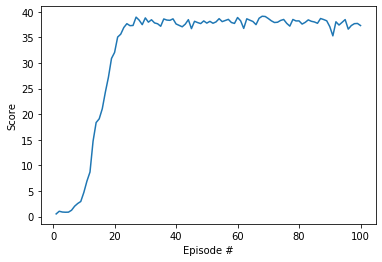

Environment solved in 7317.62 seconds


In [8]:
#==================================================================
#======================Main Program Call===========================
#==================================================================
import time
#================ Hyperpramters =========================

BUFFER_SIZE = int(1e6)  # replay buffer size
BATCH_SIZE = 512        # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR_ACTOR = 1e-4         # learning rate of the actor 
LR_CRITIC = 3e-4        # learning rate of the critic
WEIGHT_DECAY = 0   # L2 weight decay

ACTOR_HL_SIZE= [400, 300]         #Actor Hidden layers
CRITIC_HL_SIZE= [400, 300]          #Critic Hidden layers
start_time = time.time()

#Creating an Agent with statesize and action size matching the enivorment given parameters [State = 33, actions=4]
agent = Agent (num_agents, state_size, action_size, 0,
               BUFFER_SIZE, BATCH_SIZE, GAMMA, TAU, LR_ACTOR, LR_CRITIC, WEIGHT_DECAY,
              ACTOR_HL_SIZE, CRITIC_HL_SIZE)
ddpg_train(n_episodes=150, max_t=1000, print_every=10)

print("Environment solved in {:.2f} seconds".format(time.time() - start_time))

torch.save(agent.actor_local.state_dict(), '190803_actor_model.pth')
torch.save(agent.critic_local.state_dict(), '190803_critic_model.pth')


## Watching the trained Agent

In [9]:
def run_smart_agent(agent):
    env_info = env.reset(train_mode=False)[brain_name]
    states = env_info.vector_observations
    score = 0
    while True:
        actions= agent.act(states, add_noise=False)
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        states = next_states
        score += sum(rewards) / len(rewards)
        if any(dones):                                       # exit loop if episode finished
            break
    print("Score: {}".format(score))

In [10]:
#==================================================================
#======================Watch The Trained Agent ===========================
#==================================================================

ddpg_agent = Agent (num_agents, state_size, action_size, 0,
               BUFFER_SIZE, BATCH_SIZE, GAMMA, TAU, LR_ACTOR, LR_CRITIC, WEIGHT_DECAY,
              ACTOR_HL_SIZE, CRITIC_HL_SIZE)

ddpg_agent.actor_local.load_state_dict(torch.load('190803_actor_model.pth'))
ddpg_agent.critic_local.load_state_dict(torch.load('190803_critic_model.pth'))
run_smart_agent(ddpg_agent)

Score: 38.99349912842751


In [11]:
env.close()